## wap500 and org - one model

A_a - area of ascent  (wap500 < 0) <br/>
A_d - area of descent (wap500 > 0) <br/>

In [3]:
import xarray as xr
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import seaborn as sns

from os.path import expanduser
home = expanduser("~")

import timeit

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

In [4]:
def plot_snapshot(var, variable_name, cmap):
    projection = ccrs.PlateCarree(central_longitude=180)
    lat = var.lat
    lon = var.lon

    f, ax = plt.subplots(subplot_kw=dict(projection=projection), figsize=(15, 5))
    var.plot(transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal','pad':0.125, 'aspect':50,'fraction':0.055}, cmap=cmap)
    ax.add_feature(cfeat.COASTLINE)
    ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
    ax.set_title(variable_name + ' snapshot, ' + model + ', ' + experiment)
    ax.set_xticks([-180, -90, 0, 90, 180])
    ax.set_xticklabels([0, 90, 180, 270, 360])
    ax.set_yticks([-20, 0, 20])
    plt.tight_layout()

In [5]:
def plot_timeseries(y, variable_name, series_type):
    plt.figure(figsize=(25,5))
    plt.plot(y)
    plt.axhline(y=y.mean(dim='time'), color='k')
    plt.title(variable_name + ', '+ series_type + ', ' + model + ', ' + experiment)
    plt.ylabel(variable_name + ' ['+y.units+']')
    plt.xlabel(series_type)

In [6]:
def plot_scatter(x,y,scatter_type):
    f, ax = plt.subplots(figsize = (12.5,8))
    res= stats.pearsonr(x,y)

    plt.scatter(x,y,facecolors='none', edgecolor='k')
    plt.ylabel(area_option + ' [' + y.units +']')
    plt.xlabel(org_option + ' ['+ x.units +']')
    title = area_option + ' and ' + org_option + ', ' + scatter_type + ', ' + model + ', ' + experiment

    if res[1]<=0.05:
        plt.title(title + ', R$^2$ = '+ str(round(res[0]**2,3)) + ', r=' + str(round(res[0],3)))
    else:
        plt.title(title + ', not statistically significant')

In [16]:
def plot_bins(x,y, bin_type):
    plt.figure(figsize=(15,5))

    bin_width = (org.max() - org.min())/100
    bin_end = org.max()
    bins = np.arange(0, bin_end+bin_width, bin_width)

    areaFrac_bins = []
    for i in np.arange(0,len(bins)-1):
        areaFrac_bins = np.append(areaFrac_bins, areaFrac.where((org>=bins[i]) & (org<=bins[i+1])).mean())
    plt.plot(areaFrac_bins)

    plt.title(area_option + ' and ' + org_option + ', ' + bin_type + ', ' + model + ', ' + experiment)
    plt.ylabel(area_option + ' [' + y.units +']')
    plt.xlabel(org_option + ' ['+ x.units +']')


In [18]:
models = [
    # 'IPSL-CM5A-MR', # 1
    'GFDL-CM3',     
    # 'GISS-E2-H',    # 3
    # 'bcc-csm1-1',   # 4
    # 'CNRM-CM5',     # 5
    # 'CCSM4',        # 6 # cannot concatanate files for rcp85 run
    # 'HadGEM2-AO',   # 7
    # 'BNU-ESM',      # 8
    # 'EC-EARTH',     # 9
    # 'FGOALS-g2',    # 10
    # 'MPI-ESM-MR',   # 11
    # 'CMCC-CM',      # 12
    # 'inmcm4',       # 13
    # 'NorESM1-M',    # 14
    # 'CanESM2',      # 15
    # 'MIROC5',       # 16
    # 'HadGEM2-CC',   # 17
    # 'MRI-CGCM3',    # 18
    # 'CESM1-BGC'     # 19
    ]
model = models[0]


experiments=[
    'historical', 
    # 'rcp85'
    ]
experiment = experiments[0]


org_options = [
    'rome',
    # 'rome_n',
    # 'o_number'
    ]
org_option = org_options[0]


area_options = [
    'area_ascent'
    # 'area_descent'
    ]
area_option = area_options[0]


if org_option == 'rome' or org_option == 'rome_n':
    folder = home + '/Documents/data/cmip5/' + model
    fileName = model + '_rome_' + experiment + '.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)
    org = ds[org_option]

if org_option == 'o_number':
    folder = home + '/Documents/data/cmip5/' + model
    fileName = model + '_numberIndex_' + experiment + '.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)
    org = ds[org_option]


folder = home + '/Documents/data/cmip5/ds'
fileName = model + '_wap500_' + experiment + '.nc'
path = folder + '/' + fileName
ds = xr.open_dataset(path)
wap500 = ds['wap500']

if area_option == 'area_ascent':
    areaFrac = ((wap500<0)*1).sum(dim=('lat','lon'))/(wap500.shape[1]*wap500.shape[2])*100

if area_option == 'area_descent':
    areaFrac = ((wap500>0)*1).sum(dim=('lat','lon'))/(wap500.shape[1]*wap500.shape[2])*100
areaFrac.attrs['units'] = '%'


aWeights = np.cos(np.deg2rad(wap500.lat))

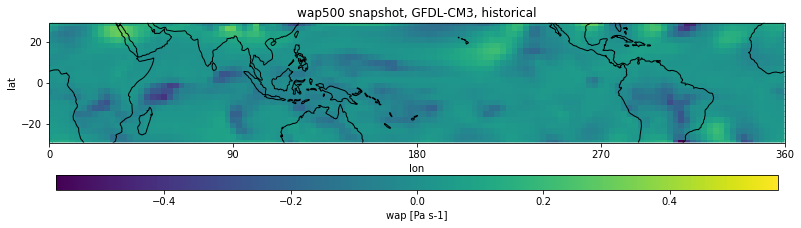

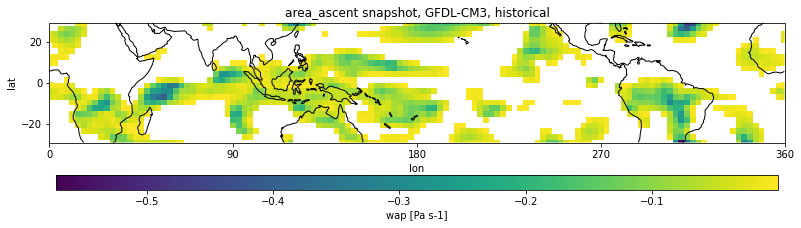

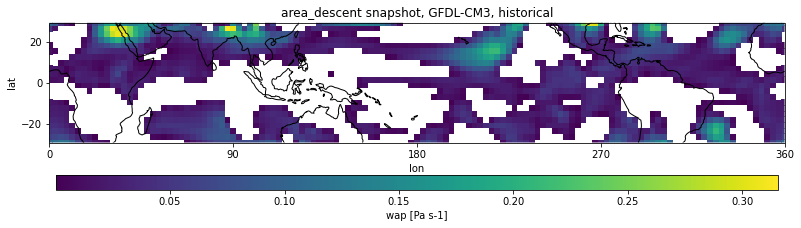

In [9]:
var = wap500.isel(time=0)
variable_name = 'wap500'
cmap = 'viridis'

plot_snapshot(var, variable_name, cmap)

var = wap500.isel(time=0).where(wap500.isel(time=0)<0, np.nan)
variable_name = 'area_ascent'
cmap = 'viridis'

plot_snapshot(var, variable_name, cmap)

var = wap500.isel(time=0).where(wap500.isel(time=0)>0, np.nan)
variable_name = 'area_descent'
cmap = 'viridis'

plot_snapshot(var, variable_name, cmap)

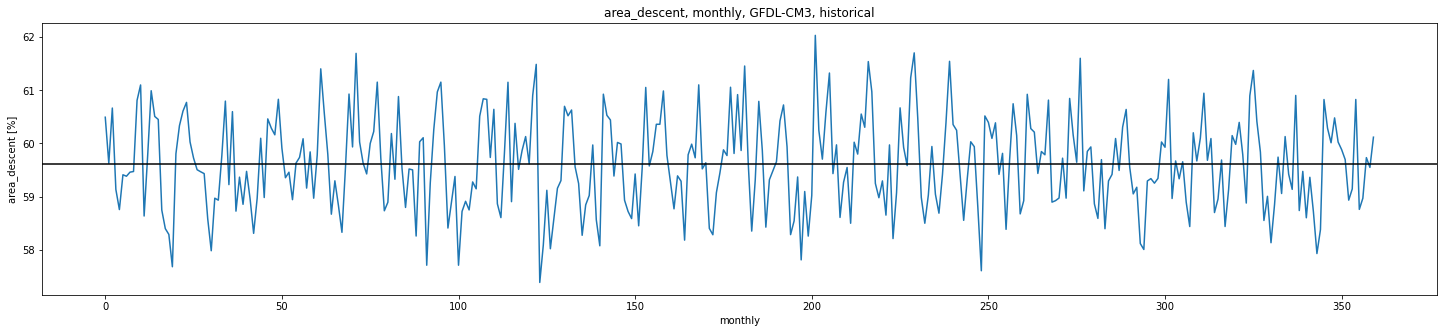

In [10]:
y = areaFrac.resample(time='M').mean(dim='time', keep_attrs=True)
variable_name = area_option
series_type = 'monthly'

plot_timeseries(y, variable_name, series_type)

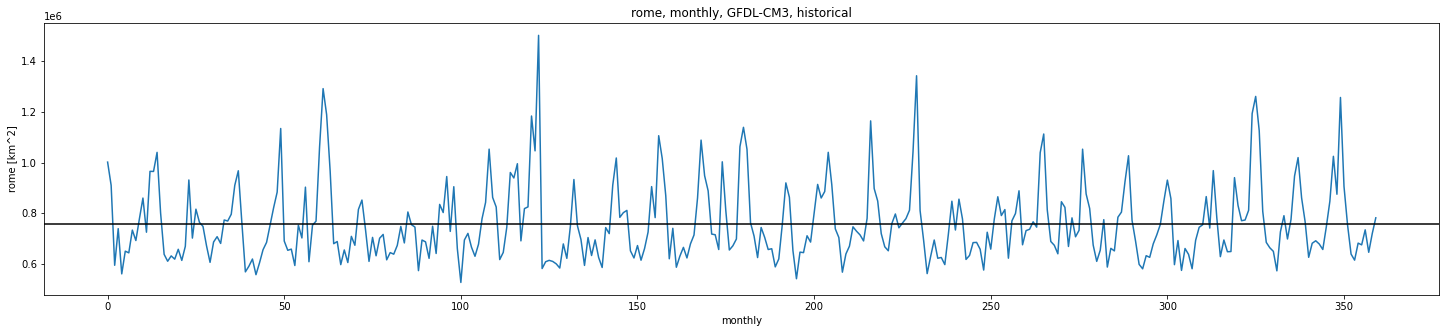

In [11]:
y = org.resample(time='M').mean(dim='time', keep_attrs=True)
variable_name = org_option
series_type = 'monthly'

plot_timeseries(y, variable_name, series_type)

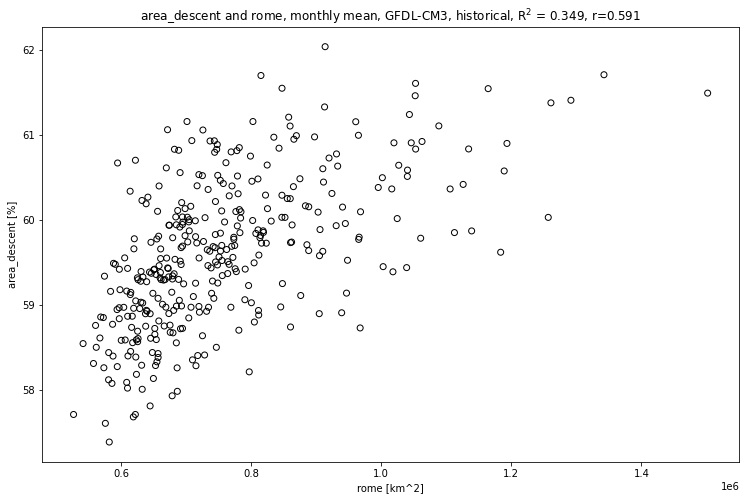

In [12]:
x = org.resample(time='M').mean(dim='time', keep_attrs=True)
y = areaFrac.resample(time='M').mean(dim='time', keep_attrs=True)
scatter_type = 'monthly mean'

plot_scatter(x,y,scatter_type)

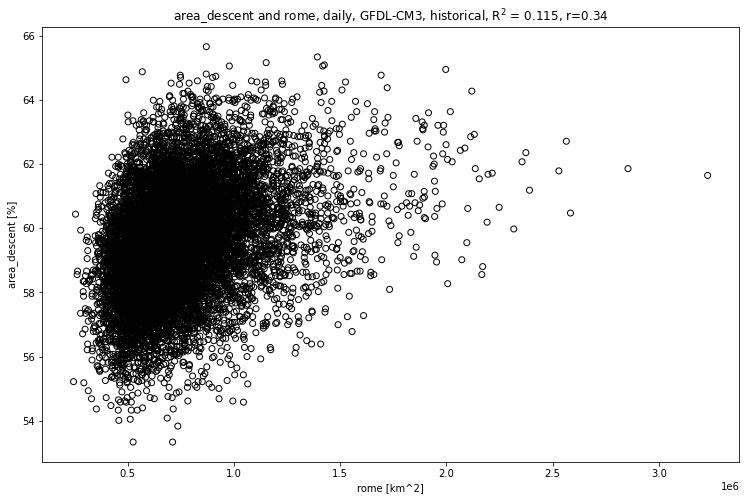

In [13]:
x = org
y = areaFrac
scatter_type = 'daily'

plot_scatter(x,y,scatter_type)

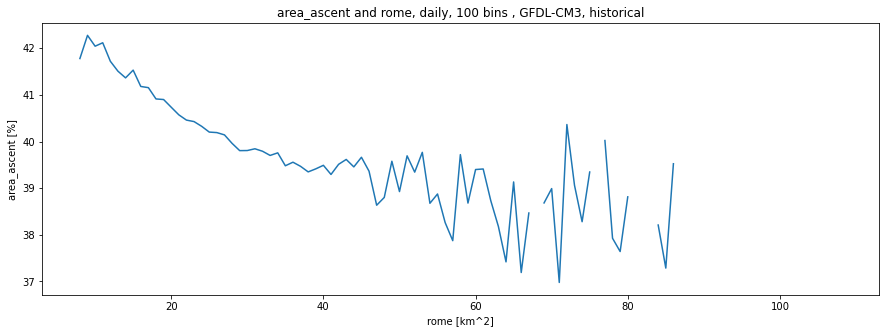

In [19]:
x = org
y = areaFrac
bin_type = 'daily, 100 bins '

plot_bins(x,y, bin_type)